### Let's look at Message passing in Torch Geometric
First install and import the relevant packages:

In [1]:
# Import the most important things
%matplotlib inline
import math
import numpy as np
import networkx
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from torch_scatter import scatter_mean
import io
import PIL

from torch_geometric.nn import MessagePassing, global_add_pool, global_mean_pool
from torch_geometric.datasets import MD17
from torch_geometric.transforms import RadiusGraph, Compose, BaseTransform, Distance, Cartesian, RandomRotate
from torch_geometric.loader import DataLoader

from tqdm import tqdm

import torch_geometric as tg
import networkx as nx
import torchvision

import os

pl.seed_everything(42, workers=True)

Global seed set to 42


42

# **2. 2D Data: Superpixel MNIST**

Superpixel MNIST contains 2D graph representations where nodes correspond to the centers of superpixel patches (pixels grouped together according to similarity) and edges with maximum length 8. We will do graph classification on this dataset.

The message passing scheme as described in 2 does not explicitly take the geometric structure between the nodes into account; they act only on the feature vectors $f_i$ on the nodes, but not their position (that is, any structure between their position vectors $x_i$). For example, the current MPNN scheme is invariant to rotations and distance between nodes,
and hence immediately discards this information when building the node representations.

We will build node representation that respect the geometry of the manifold on which the graph lives. We will do this by injecting various geometric quantities into the edge embeddings, for example the distance between nodes, or their relative position. These choices are invariant/equivariant with respect to different groups and we will vary the input to explore how feature vectors transform under rotations.

In [21]:
import torch
from sklearn.cluster import KMeans
from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform

class KMeansClustering(BaseTransform):
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters

    def fit(self, data):
        pos = data.pos
        x = data.x

        N = data.num_nodes
        k = N // self.num_clusters

        pos_flattened = pos.view(-1, pos.size(-1)).numpy()

        kmeans = KMeans(n_clusters=k, n_init=12)
        self.labels = kmeans.fit_predict(pos_flattened)
        self.labels = torch.from_numpy(self.labels)  # Convert labels to torch.Tensor
        self.centroids_pos = torch.zeros(k, pos.size(-1))
        self.centroids_x = torch.zeros(k, x.size(-1))

        for node_idx, cluster_idx in enumerate(self.labels):
            self.centroids_pos[cluster_idx] += pos[node_idx]
            self.centroids_x[cluster_idx] += x[node_idx]

        for cluster_idx in range(k):
            indices = torch.nonzero(self.labels == cluster_idx).view(-1)
            count = indices.size(0)

            self.centroids_pos[cluster_idx] /= count
            self.centroids_x[cluster_idx] /= count

    def __call__(self, data):
        pos = data.pos
        x = data.x

        # Assign the precomputed centroids and labels
        data.x = self.centroids_x
        data.x_full = x
        data.pos = self.centroids_pos
        data.pos_full = pos
        data.cluster_labels = self.labels

        return data

In [22]:
import os
from typing import Callable, List, Optional

import torch
from torch_geometric.data import Data, InMemoryDataset, download_url, extract_zip
from tqdm import tqdm

class MNISTSuperpixels(InMemoryDataset):
    url = 'https://data.pyg.org/datasets/MNISTSuperpixels.zip'

    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        cluster_k: int = None,
    ):
        self.cluster_k = cluster_k  # Store cluster_k for later use
        super().__init__(root, transform, pre_transform, pre_filter)
        path = self.processed_paths[0] if train else self.processed_paths[1]
        self.data, self.slices = torch.load(path)

    @property
    def raw_file_names(self) -> str:
        return 'MNISTSuperpixels.pt'

    @property
    def processed_file_names(self) -> List[str]:
        if self.cluster_k is None:
            return ['train_data.pt', 'test_data.pt']
        else:
            return [f'train_data_k{self.cluster_k}.pt', f'test_data_k{self.cluster_k}.pt']

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.unlink(path)

    def process(self):
        inputs = torch.load(self.raw_paths[0])
        for i in range(len(inputs)):
            data_list = [Data(**data_dict) for data_dict in inputs[i]]

            if self.pre_filter is not None:
                data_list = [d for d in data_list if self.pre_filter(d)]

            if self.pre_transform is not None:
                data_list = [self.pre_transform(d) for d in data_list]

            if self.cluster_k is not None:
                with tqdm(total=len(data_list), desc=f'Cluster K={self.cluster_k}') as pbar:
                    for j in range(len(data_list)):
                        cluster_transform = KMeansClustering(num_clusters=self.cluster_k)
                        cluster_transform.fit(data_list[j])
                        data_list[j] = cluster_transform(data_list[j])
                        pbar.update(1)

            torch.save(self.collate(data_list), self.processed_paths[i])

In [23]:
dataset = MNISTSuperpixels(root='./datasets', train=True, cluster_k=3)

Processing...
Cluster K=3: 100%|██████████| 10000/10000 [05:43<00:00, 29.15it/s]
Done!


In [25]:
import os
import torch
import torch_geometric
from torch_geometric.transforms import RadiusGraph, Compose

batch_size = 64
radius = 8


# Regular dataloaders
transforms = [RadiusGraph(radius)]
transforms = Compose(transforms)
#transforms = None
train_set = MNISTSuperpixels(root='./datasets', transform=transforms, train=True)
train_set_kmeans = MNISTSuperpixels(root='./datasets', transform=transforms, train=True, cluster_k=3)
# image mnist for visualizations
train_set_regular = torchvision.datasets.MNIST(root='./datasets', train=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]), download=True)
val_set_regular = torchvision.datasets.MNIST(root='./datasets', train=False, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]), download=True)

 Here we can see what a datasample looks like (original image is plotted underneath):

In [26]:
def visualize_sample(idx, data, regular_data):

    
    sample_graph = data[idx].clone()
    sample_graph.pos -= sample_graph.pos.min()
    sample_graph.pos = sample_graph.pos/sample_graph.pos.max() * 2 - 1
    
    
    sample_mnist = regular_data[idx][0].squeeze(0)

    pos_dict = {}
    print(f"Digit: {sample_graph.y.item()}")
    for i, p in enumerate(sample_graph.pos):
        pos_dict[i] = p.numpy() * np.array([1, -1])

    
    g = tg.utils.to_networkx(sample_graph, to_undirected=True)

    f, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(sample_mnist.numpy(), extent=[-1,1,-1,1], cmap='Purples')
    nx.draw_networkx_nodes(g, 
                           node_size=500, 
                           node_color=sample_graph.x.cpu().numpy(), 
                           node_shape=r'$\circ$', 
                           pos=pos_dict,
                           cmap='Purples')

    nx.draw_networkx_edges(g, edge_color='r', alpha=0.5, pos=pos_dict)

Recall that for batch processing of N graphs, PyG builds a single composite graph where the N graphs are disconnected. Hence, the batch element assigns to each node the index of which of the N graphs it belongs to.



In the following we will train the MPNNs with three types of edge embeddings: 


*   No edge attributes
*   Euclidean distance
*   Relative distance vector

In [33]:
idx = 1
original_data = train_set[idx]
kmeans_data = train_set_kmeans[idx]

Digit: 0


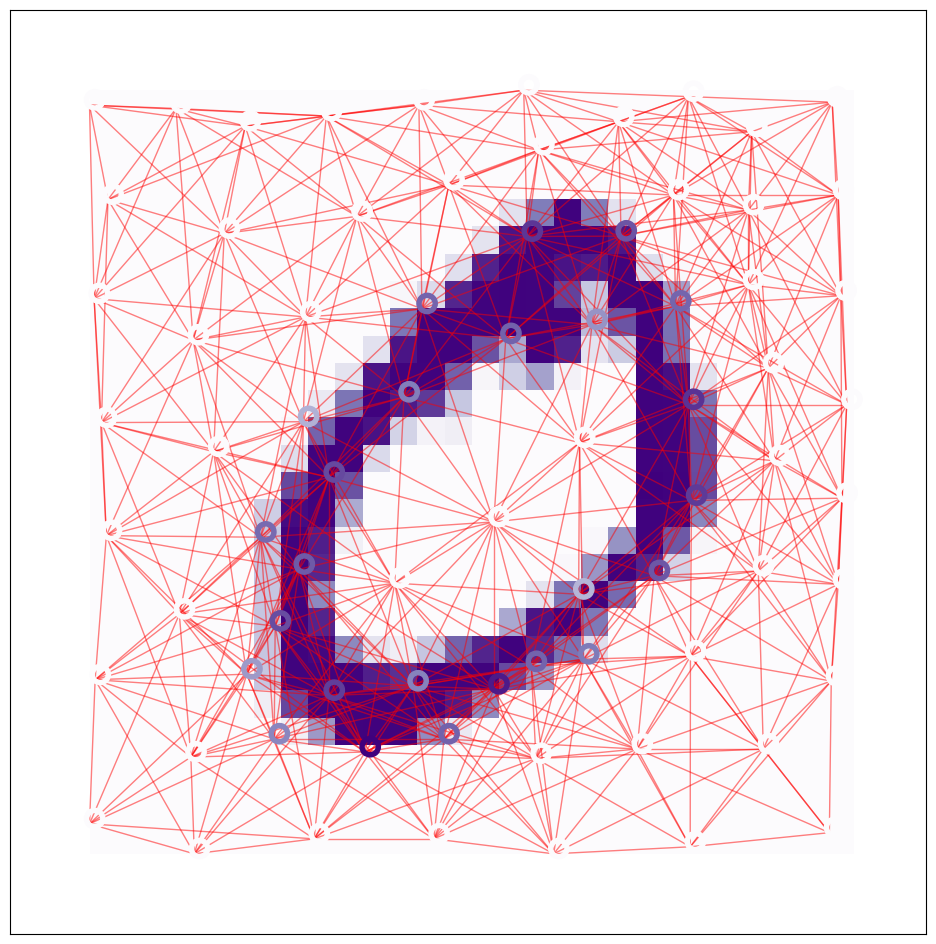

In [34]:
visualize_sample(idx, train_set, train_set_regular)

Digit: 0


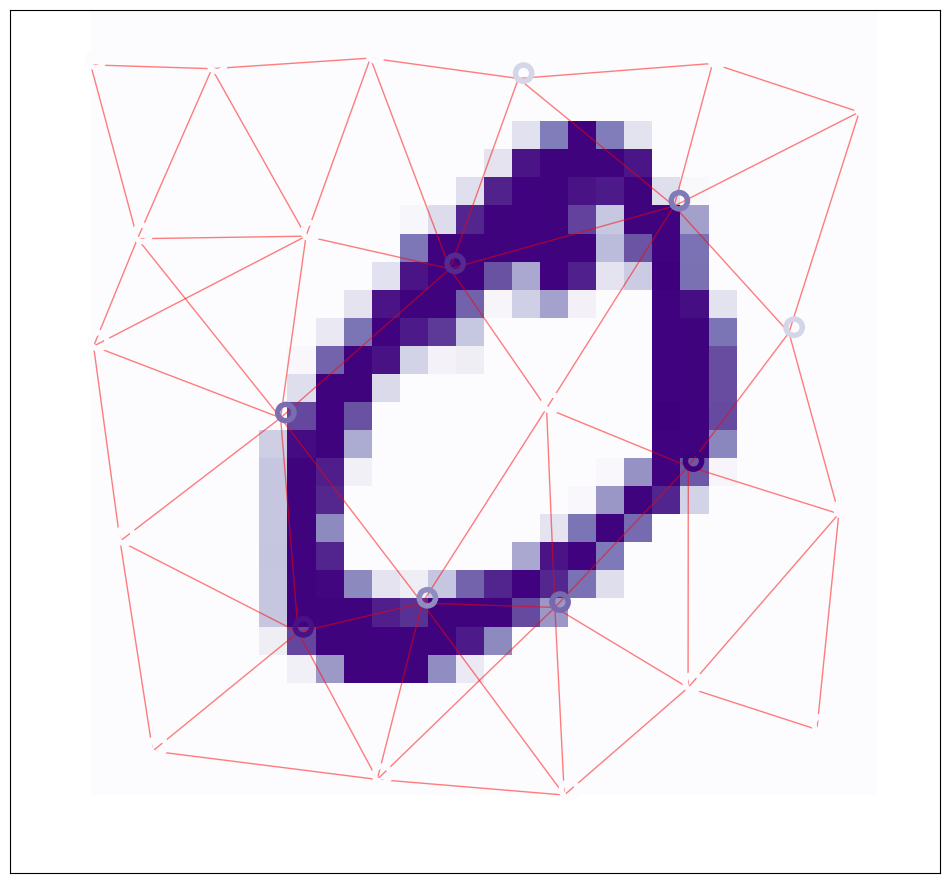

In [35]:
visualize_sample(idx, train_set_kmeans, train_set_regular)

In [40]:
from torch_scatter import scatter

In [71]:
class EGNN_FullLayer(MessagePassing):
    """ E(n)-equivariant Message Passing Layer """
    def __init__(self, node_features, edge_features, hidden_features, out_features, dim=2, aggr="mean", act=nn.ReLU):
        super().__init__(aggr=aggr)
        self.dim = dim

        self.message_net = nn.Sequential(nn.Linear(2 * node_features + edge_features, hidden_features),
                                         act(),
                                         nn.Linear(hidden_features, hidden_features))

        self.update_net = nn.Sequential(nn.Linear(node_features + hidden_features, hidden_features),
                                        act(),
                                        nn.Linear(hidden_features, out_features))

        self.pos_net = nn.Sequential(nn.Linear(hidden_features, hidden_features),
                                     act(),
                                     nn.Linear(hidden_features, 1))

        nn.init.xavier_uniform_(self.pos_net[-1].weight, gain=0.001)



    def forward(self, x, pos, edge_index, edge_attr=None):

        x = self.propagate(edge_index, x=x, pos=pos, edge_attr=edge_attr)
        return x

    def message(self, x_i, x_j, pos_i, pos_j, edge_attr):
        """ Create messages """
        input = [x_i, x_j] if edge_attr is None else [x_i, x_j, edge_attr]
        input = torch.cat(input, dim=-1)
        message = self.message_net(input)

        pos_message = (pos_i - pos_j)*self.pos_net(message)
        message = torch.cat((message, pos_message), dim=-1)
        return message

    def update(self, message, x, pos):
        """ Update node features and positions """
        node_message, pos_message = message[:, :-self.dim], message[:, -self.dim:]
        # Update node features
        input = torch.cat((x, node_message), dim=-1)
        update = self.update_net(input)
        # Update positions
        pos += pos_message
        return update, pos

In [81]:
class Superpixel_EGNN(nn.Module):
    def __init__(
            self,
            depth=5,
            hidden_features=128,
            node_features=1,
            out_features=1,
            activation="relu",
            norm="layer",
            aggr="sum",
            mask=True,
            pool="add",
            residual=True,
            **kwargs
    ):
        """E(n) Equivariant GNN model

        Args:
            depth: (int) - number of message passing layers
            hidden_features: (int) - hidden dimension
            node_features: (int) - initial node feature dimension
            out_features: (int) - output number of classes
            activation: (str) - non-linearity within MLPs (swish/relu)
            norm: (str) - normalisation layer (layer/batch)
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
            pool: (str) - global pooling function (sum/mean)
            residual: (bool) - whether to use residual connections
        """
        super().__init__()
        # Name of the network
        self.name = "Superpixel_EGNN"
        self.depth = depth
        self.mask = mask
        self.residual = residual
        # Embedding lookup for initial node features
        self.emb_in = nn.Linear(node_features, hidden_features)

        # Stack of GNN layers
        self.ground_mps = torch.nn.ModuleList()
        self.ground_to_sub_mps = torch.nn.ModuleList()
        self.sub_mps = torch.nn.ModuleList()
        for layer in range(depth):
            #ode_features, edge_features, hidden_features, out_features, dim=2, aggr="mean", act=nn.ReLU):
            #self.convs.append(EGNN_FullLayer(hidden_features, edge_features=1, hidden_features=hidden_features, out_features=hidden_features, dim=2, aggr="mean", act=nn.ReLU))
            self.ground_mps.append(EGNN_FullLayer(hidden_features, edge_features=1, hidden_features=hidden_features, out_features=hidden_features, dim=2, aggr="mean", act=nn.ReLU))
            self.ground_to_sub_mps.append(EGNN_FullLayer(hidden_features, edge_features=1, hidden_features=hidden_features, out_features=hidden_features, dim=2, aggr="mean", act=nn.ReLU))
            self.sub_mps.append(EGNN_FullLayer(hidden_features, edge_features=1, hidden_features=hidden_features, out_features=hidden_features, dim=2, aggr="mean", act=nn.ReLU))

        '''
        # Global pooling/readout function
        self.pool = {"mean": tg.nn.global_mean_pool, "add": tg.nn.global_add_pool}[pool]

        # Predictor MLP
        self.pred = torch.nn.Sequential(
            torch.nn.Linear(hidden_features, hidden_features),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_features, out_features)
        )
        self.residual = residual
        '''

    def forward(self, batch):

        h = self.emb_in(batch.x)  # (n,) -> (n, d)
        pos = batch.pos  # (n, 3)

        for layer_idx in range(self.depth):
            # Message passing layer
            edge_index = batch.edge_index
            dist = torch.sum((pos[edge_index[1]] - pos[edge_index[0]]).pow(2), dim=-1, keepdim=True).sqrt()
            h_old = h.clone()
            h_0 = h
            pos_old = pos.clone()
            h, pos = self.ground_mps[layer_idx](h, pos, edge_index, dist)
            h = h + h_0 if self.residual else h
            if self.mask:
                h[~batch.ground_node] = h_old[~batch.ground_node]
                pos[~batch.ground_node] = pos_old[~batch.ground_node]
            #TODO: CONTINUE MODIFYING EGNN TO SUPERPIXEL EGNN BY FIXING THE LAYERS BELOW
            # Ground to subnode message passing layer
            h_old = h.clone()
            pos_old = pos.clone()
            h_update, pos_update = self.ground_to_sub_mps[layer_idx](h, pos, batch.node_subnode_index)
            h = h + h_update if self.residual else h_update
            pos = pos_update
            if self.mask:
                h[batch.ground_node] = h_old[batch.ground_node]
                pos[batch.ground_node] = pos_old[batch.ground_node]

            # Subnode message passing layer
            h_old = h.clone()
            pos_old = pos.clone()
            h_update, pos_update = self.sub_mps[layer_idx](h, pos, batch.subgraph_edge_index)
            h = h + h_update if self.residual else h_update
            pos = pos_update
            if self.mask:
                h[batch.ground_node] = h_old[batch.ground_node]
                pos[batch.ground_node] = pos_old[batch.ground_node]

        superpixel_pos = pos[~batch.ground_node]
        superpixel_h = h[~batch.ground_node]
        return superpixel_pos, superpixel_h

In [82]:
# include the utils folder so i can import scripts from it
import sys
sys.path.insert(0, './utils')
from utils.transforms import Graph_to_Subgraph

radius = 8
# Regular dataloaders
transforms = [RadiusGraph(radius)]
transforms.append(Graph_to_Subgraph(mode='transformer_3'))
transforms = Compose(transforms)
train_set = MNISTSuperpixels(root='./datasets', transform=transforms, train=True, cluster_k=3)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

In [83]:
# Initialize the network
model = Superpixel_EGNN(depth=4,
                        hidden_features=64,
                        node_features=4,
                        mask=True,
                        residual=True)
# Get a sample from the dataloader
batch = next(iter(train_loader))
# Pass the batch through the network
superpixel_pos, superpixel_h = model(batch)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (300x128 and 129x64)